----
# <center>Bias and Diversity in Synthetic-based Face Recognition</center>
**<center>(are fake faces less diverse??)**</center>

----
## <center>Jason Mai, May Blair, Yuri Lee</center>


<div>
<center>
<img src="ipynb_img/title.png" width="900"/>
</center>
</div>

It all began when we found this paper describing the results of training generative face models on different datasets. Pulling images of human faces from the internet's generous stock, they were able to test their  model on both authentic and synthetic datasets. When comparing different models' outputs, they discovered the bias remained, and sometimes was exaggerated.

<div>
<center>
<img src="ipynb_img/abstract.png" width="400"/>
</center>
</div>

Let's break down what this says. The comparison they want to explore is generating faces from authentic data (real images of human faces) versus synthetic data (images of faces generated from a model trained on real faces).

<div>
<center>
<img src="ipynb_img/maydiagram.png" width="400"/>
</center>
</div>

One dataset is CASIA-WebFace and the other dataset is the output of running StyleGAN-2 on CASIA-WebFace. Essentially, the synthetic data is one step away from real data. They used each dataset to train a ResNET-50 model, a residual neural network with 50 layers of training. Then, they asked each model to generate faces and compared the distribution of their outputs.

For the purposes of this presentation, we will be focusing on their results from the category of gender. Although there are more than two known genders, this paper made it a binary male or female label.

<div>
<center>
<img src="ipynb_img/bar-graph.png" width="500"/>
</center>
</div>


Although their goal is to compare the datasets of fake faces ***generated*** by the models, they first compare the distribution of the original datasets used to ***train*** the models. We will follow them and first look at datasets 1 and 2, CASIA-Webface, the authentic dataset from the internet, and SFace-60, the dataset produced by StyleGAN-2 (model trained on CASIA-Webface dataset).

Their findings are shown in the first two bars in the graph. In order to replicate their results, we looked for both the StyleGAN-2 model and the  SFace-60 dataset that it produces. Here is our hunt.

----
# <center>Step 1a</center>

## <center>find CASIA-Webface (authentic) dataset</center>
----

We quickly find the folder of authentic faces [CASIA-WebFace](https://www.kaggle.com/datasets/debarghamitraroy/casia-webface), but before we can access images from it, we must convert the ```train.rec``` file into a folder of ```*.jpg```s. The way you do that is by parsing it through this [script](https://github.com/eeric/Face_recognition_cnn/blob/main/code/insightface/README.md).

In [ ]:
import numpy as np
import mxnet as mx
from mxnet import recordio
import matplotlib.pyplot as plt
import cv2
import os
path_imgidx = '/faces_webface_112x112/train.rec' # path to train.rec
path_imgrec = '/final-project/faces_webface_112x112/train.idx' # path to train.idx

imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
#%% 1 ~ 3804847
for i in range(3000):
        print(i)
        header, s = recordio.unpack(imgrec.read_idx(i+1))
        img = mx.image.imdecode(s).asnumpy()
        path = os.path.join('images',str(header.label))
        if not os.path.exists(path):
                os.makedirs(path)
        path = os.path.join(path,str(i))
        (b,g,r)=cv2.split(img)
        img = cv2.merge([r,g,b])
        print((img.shape))
        cv2.imwrite(path+'.jpg',img)

Now the CASIA-Webface images are all stored as ```*.jpg```s in our [respository]( https://github.com/jsnmai/FR-Project).

----
# <center>Step 1b</center>

## <center>find StyleGAN-2 model / SFace-60 dataset</center>
----

Now with our data in the correct format, we can run it through StyleGAN-2 to produce a batch of fake faces. We found the StyleGAN-2 model in the [stylgan2-repository](https://github.com/NVlabs/stylegan2-ada-pytorch). However, training the model on our data requires 8 high-end NVIDIA GPUs  and atleast 1-3 days to complete.

<div>
<center>
<img src="ipynb_img/sface-visual.png" width="300"/>
</center>
</div>

So, we pivoted to using a [sface-respository](https://github.com/fdbtrs/sface-privacy-friendly-and-accurate-face-recognition-using-synthetic-data) which contained the output we needed, a dataset of faces generated by the StyleGAN-2 model trained on CASIA-Webface. We found this repository in a [sface-paper](https://arxiv.org/pdf/2206.10520) exploring accuracy in facial recognition software.

----
# <center>Step 2</center>

## <center>train classifier</center>
----

Now that we have our first two datasets to compare, we need to classify the data by gender to find the distribution of male to female faces. It isn’t feasible to create the same exact classifier with the fine-tuning described in the study since that process requires training across 100+ GBs of IMDB-Wiki photos, so we use a similar pretrained model created in this [notebook](https://www.kaggle.com/code/yasserhessein/gender-classification-using-vgg16-cnn/notebook).

<div>
<center>
<img src="ipynb_img/vgg16-architecture.jpg" width="800"/>
</center>
</div>

We will now load in the VGG16 classifier and fine-tune its training. For the SFace classifier, we will train on a general [gender dataset](https://www.kaggle.com/datasets/yasserhessein/gender-dataset). The CASIA classifier will be finetuned on 100 pictures from CASIA-Webface. 

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

batch_size = 6
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=10
validation_steps=10
epochs=6

Creation of SFace classifier model:

In [ ]:
sf_train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

sf_test_datagen = ImageDataGenerator( rescale = 1.0/255)

sf_train_generator = sf_train_datagen.flow_from_directory('Kaggle/Train',
                                                    batch_size =batch_size ,
                                                    class_mode = 'binary',
                                                    seed=seed,
                                                    target_size = target_size)

sf_validation_generator =  sf_test_datagen.flow_from_directory('Kaggle/Test',
                                                    batch_size  = batch_size,
                                                    class_mode  = 'binary',
                                                    seed=seed,
                                                    target_size = target_size)


In [ ]:
sf_model = load_model("VGG16.h5")
sf_model.compile(optimizer=Adam(adam),
                loss='binary_crossentropy',
                metrics=['accuracy'])
# sf_model.summary()

Creation of CASIA classifier model:

In [ ]:
ca_train_datagen = ImageDataGenerator(rescale = 1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

ca_test_datagen = ImageDataGenerator( rescale = 1.0/255)

ca_train_generator = ca_train_datagen.flow_from_directory('casia-images/casia_validation',
                                                batch_size = batch_size,
                                                class_mode = "binary",
                                                seed=seed,
                                                target_size = target_size )   
  
ca_validation_generator = ca_test_datagen.flow_from_directory('casia-images/casia_validation',
                                                batch_size = batch_size,
                                                class_mode = "binary",
                                                seed=seed,
                                                target_size = target_size )  

In [ ]:
ca_model = load_model("VGG16.h5")
ca_model.compile(optimizer=Adam(adam),
                loss='binary_crossentropy',
                metrics=['accuracy'])
# casia_model.summary()

Now that we have the classifiers, we need to see how accurate they are at classifying their respective datasets. So, we define a plotting function to show a histograph of the accuracy of the model over a very short training period. We cannot show more data crunching than this due to computer limitations.

In [45]:

def plot_accuracy(model, data):
    if data == "CASIA":
        validation_data=ca_validation_generator
        hist = model.fit(ca_train_generator,steps_per_epoch=steps_per_epoch,
                         validation_data=validation_data,
                         validation_steps=validation_steps,epochs=epochs)
    elif data == "SFace":
        validation_data=sf_validation_generator
        hist = model.fit(sf_train_generator,steps_per_epoch=steps_per_epoch,
                         validation_data=validation_data,
                         validation_steps=validation_steps,epochs=epochs)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
    plt.title(data + " classifier accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.show()
    return

We first tested the classifier's accuracy on the SFace-60 dataset:

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step - accuracy: 0.7818 - loss: 0.4123 - val_accuracy: 0.6500 - val_loss: 0.5949
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.9116 - loss: 0.5766 - val_accuracy: 0.9667 - val_loss: 0.2701
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.7722 - loss: 0.6661 - val_accuracy: 0.8833 - val_loss: 0.5911
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.8128 - loss: 0.3438 - val_accuracy: 0.7333 - val_loss: 5.4661
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.7954 - loss: 0.4283 - val_accuracy: 0.8833 - val_loss: 0.8410
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 352ms/step - accuracy: 0.9027 - loss: 0.3048 - val_accuracy: 0.9167 - val_loss: 0.2634


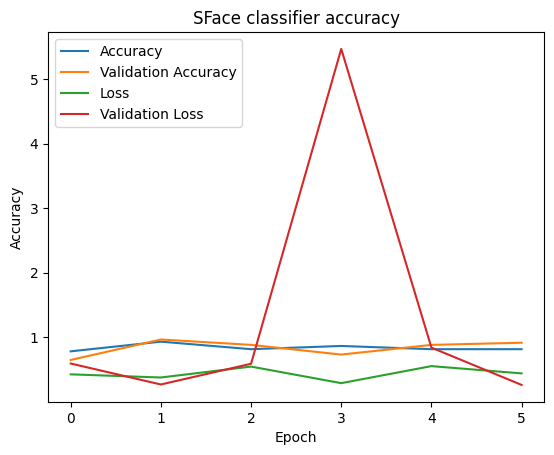

In [30]:
plot_accuracy(sf_model, "SFace")

This seemed to be relatively, consistently 75-95% accurate.

Then we tested the classifier's accuracy on the CASIA-Webface dataset:

Epoch 1/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.7285 - loss: 1.0452 - val_accuracy: 0.5833 - val_loss: 0.6394
Epoch 2/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.6782 - loss: 0.6755 - val_accuracy: 0.6167 - val_loss: 0.6160
Epoch 3/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.7805 - loss: 0.4915 - val_accuracy: 0.8667 - val_loss: 0.3950
Epoch 4/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.8543 - loss: 0.3601 - val_accuracy: 0.8167 - val_loss: 0.3654
Epoch 5/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.9018 - loss: 0.3621 - val_accuracy: 0.7000 - val_loss: 0.9210
Epoch 6/6
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.8630 - loss: 0.4259 - val_accuracy: 0.6000 - val_loss: 1.7080


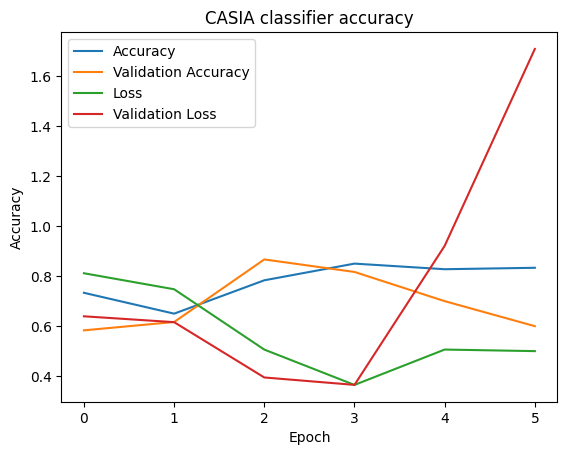

In [41]:
plot_accuracy(ca_model, "CASIA")

This was a much less consistent result, but averaged 65-90% accuracy.

----
# <center>Step 3</center>

## <center>classify our data</center>
----

Assuming the classifier is 90% accurate on the SFace-60 dataset and 86% accurate on the CASIA-Webface dataset, we tested it on evenly (50/50) distributed subsets of the actual datasets:

In [2]:
def plot_data(ca_male, ca_female, sf_male, sf_female):
    
    ca_male_per = ca_male / (ca_male + ca_female) * 100
    ca_female_per = ca_female / (ca_male + ca_female) * 100

    sf_male_per = sf_male / (sf_male + sf_female) * 100
    sf_female_per = sf_female / (sf_male + sf_female) * 100
    
    labels = ["SFace-60", "CASIA"]
    males = [sf_male_per, ca_male_per]
    females = [sf_female_per, ca_female_per]
    fig, graph = plt.subplots(layout='constrained')

    b1 = graph.barh(labels, males, label='Male', color='green')
    b2 = graph.barh(labels, females, left=males, label='Female', color='orange')

    graph.set_title('Gender Classification Percentages')
    graph.set_yticks(labels)
    graph.set_xlabel('Percentage (%)')
    plt.xlim(0, 100)
    graph.legend(loc='upper left', ncols=1)
    
    plt.show()

This is how we will count how many females/males are identified:

In [3]:
def count(paths, data):
    male_count = 0
    female_count = 0

    if "casia" in data:
        model = ca_model
        max_img = 50 if data == "casia test" else 500
    elif "sf" in data:
        # model = sf_model
        model = ca_model
        max_img = 50 if data == "sf test" else 500
    for path in paths:
        image_count = 0
        for file in os.listdir(path):
            if file[:-4:-1] in ["gpj", "gnp"]:
                if image_count >= max_img:  
                    break
                image_path = os.path.join(path, file)
                print(image_path)
                img = image.load_img(image_path,target_size=target_size)
                img = np.asarray(img)
                # plt.imshow(img)
                img = np.expand_dims(img, axis=0)
                output = model.predict_on_batch(img)
                if output[0] > 0.5:
                    # print("female")
                    female_count += 1
                else:
                    # print("male")
                    male_count += 1
                image_count += 1
    return male_count, female_count

Now we will verify with the 50/50 datasets:

FR-project/images/casia_validation/females/77.jpg
FR-project/images/casia_validation/females/2869.jpg
FR-project/images/casia_validation/females/88.jpg
FR-project/images/casia_validation/females/2276.jpg
FR-project/images/casia_validation/females/2289.jpg
FR-project/images/casia_validation/females/957.jpg
FR-project/images/casia_validation/females/1555.jpg
FR-project/images/casia_validation/females/2935.jpg
FR-project/images/casia_validation/females/2921.jpg
FR-project/images/casia_validation/females/2920.jpg
FR-project/images/casia_validation/females/2934.jpg
FR-project/images/casia_validation/females/1554.jpg
FR-project/images/casia_validation/females/956.jpg
FR-project/images/casia_validation/females/2288.jpg
FR-project/images/casia_validation/females/2277.jpg
FR-project/images/casia_validation/females/89.jpg
FR-project/images/casia_validation/females/2868.jpg
FR-project/images/casia_validation/females/76.jpg
FR-project/images/casia_validation/females/2275.jpg
FR-project/images/casi

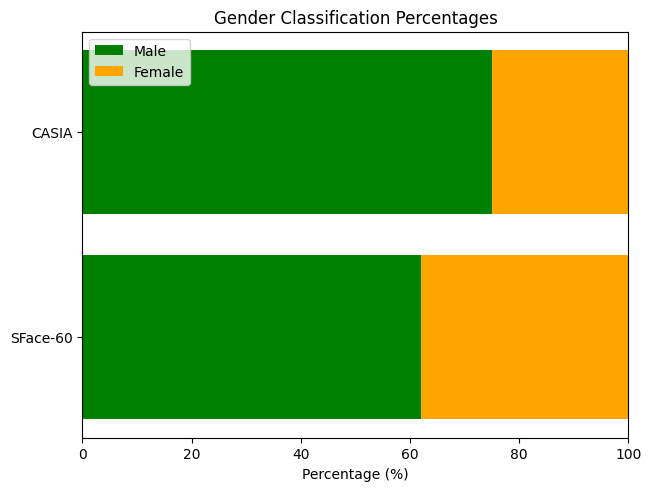

casia: M-75 F-25
sface: M-62 F-38


In [ ]:
casia_paths = ['casia-images/casia_validation/females','casia-images/casia_validation/males']
sface_paths = ['sfacesubset/train/female', 'sfacesubset/train/male']
ca_male, ca_female = count(casia_paths, "casia test")
sf_male, sf_female = count(sface_paths, "sf test")
plot_data(ca_male, ca_female, sf_male, sf_female)
print("casia: M-" + str(ca_male) + " F-" + str(ca_female))
print("sface: M-" + str(sf_male) + " F-" + str(sf_female))

Fine. Not really 90% accurate on the SFace-60 dataset and 86% accurate on the CASIA-Webface dataset, but good enough. Weirdly, when we use the CASIA classifier on the SFace dataset, the results are more accurate. So we will use the CASIA classifier on both datasets. 

----
# <center>Step 4</center>

## <center>compare actual data</center>
----

Now we will randomly sample from both the CASIA-Webface and SFace-60 datasets to determine how many female/male faces they contain with our (mediocre) classifier:

FR-Project/images/train/casia/63.jpg
FR-Project/images/train/casia/823.jpg
FR-Project/images/train/casia/2666.jpg
FR-Project/images/train/casia/2100.jpg
FR-Project/images/train/casia/1409.jpg
FR-Project/images/train/casia/189.jpg
FR-Project/images/train/casia/2114.jpg
FR-Project/images/train/casia/2672.jpg
FR-Project/images/train/casia/77.jpg
FR-Project/images/train/casia/837.jpg
FR-Project/images/train/casia/2882.jpg
FR-Project/images/train/casia/1353.jpg
FR-Project/images/train/casia/1435.jpg
FR-Project/images/train/casia/2128.jpg
FR-Project/images/train/casia/1421.jpg
FR-Project/images/train/casia/1347.jpg
FR-Project/images/train/casia/2896.jpg
FR-Project/images/train/casia/638.jpg
FR-Project/images/train/casia/2869.jpg
FR-Project/images/train/casia/1390.jpg
FR-Project/images/train/casia/604.jpg
FR-Project/images/train/casia/2699.jpg
FR-Project/images/train/casia/2841.jpg
FR-Project/images/train/casia/162.jpg
FR-Project/images/train/casia/176.jpg
FR-Project/images/train/casia/2855.j

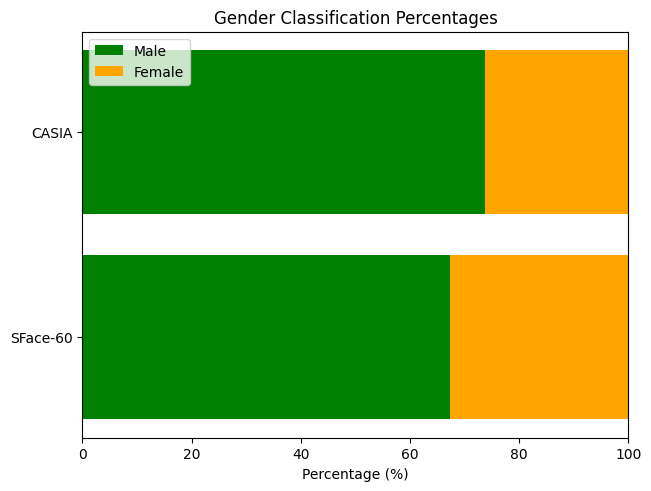

casia: M-369 F-131
sface: M-337 F-163


In [66]:
casia_paths = ['casia-images/train']
sface_paths = ['sfacesubset/test']
ca_male, ca_female = count(casia_paths, "casia")
sf_male, sf_female = count(sface_paths, "sf")
plot_data(ca_male, ca_female, sf_male, sf_female)
print("casia: M-" + str(ca_male) + " F-" + str(ca_female))
print("sface: M-" + str(sf_male) + " F-" + str(sf_female))

To summarize, we attempted to replicate how the study looked at the gender distribution of datasets. We chose to look at 2 of the 5 they used: a real dataset, CASIA-WebFace, and a synthetic dataset, SFace-60. 

Our results reflected the **same relationship** between the datasets as the study; the synthetic data mirrors the authentic data's bias towards males. However, our model shows **reduced** bias in the synthetic dataset, but the study found that  the synthetic dataset actually **increased** the existing bias in authentic data.

To determine the total number of male and female faces in these respective datasets, the original study had used VGG-16 pretrained and fine-tuned on the IMDB-wiki dataset to classify. In our limited recreation of this, so our VGG-16 classifier model was fine-tuned on a **different dataset** (found on Kaggle). Additionally, we were unable to generate the synthetic data ourselves, and we could only classify a **much  smaller subset** of the total data. This explains the difference in our results compared to the original.

In the future, we would have the same tools (accurate classifier and GPUs) as those who studied this to obtain more accurate classifications. This is crucial to identifying if there truly is more bias in synthetic image generation.